# Mean bias correction

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:30:00'
cores = 24
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36987 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client#.restart()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36987/status,
Dashboard: /proxy/36987/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.2:41381,Workers: 0
Dashboard: /proxy/36987/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [33]:
import xarray as xr
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.pyplot as plt

In [2]:
path_model = "/g/data/w42/dr6273/work/data/CMIP6/ACCESS-ESM1-5/historical/day/"
path_era = "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/"

In [11]:
def open_model(var):
    """
    Open ACCESS zarr collection
    """
    return xr.open_zarr(
        path_model + var + "/" + var + "_day_ACCESS-ESM1-5_historical_1950-2014_NEM.zarr",
        consolidated=True
    )

In [4]:
def open_era(var):
    """
    Open ERA5 data regridded to ACCESS grid
    """
    return xr.open_mfdataset(
        path_era + var + "_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
    )

### Temperature (2m)

In [16]:
tas_model = open_model("tas").sel(time=slice("1959", "2014"))

In [17]:
tas_model

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 12, member: 40, time: 20454)
Coordinates:
  * lat      (lat) float64 -45.0 -43.75 -42.5 -41.25 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 133.1 135.0 136.9 138.8 ... 148.1 150.0 151.9 153.8
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) datetime64[ns] 1959-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    tas      (member, time, lat, lon) float32 dask.array<chunksize=(5, 14975, 29, 12), meta=np.ndarray>

In [18]:
tas_era = open_era("2t").rename({"t2m": "tas"})

In [19]:
tas_era

<xarray.Dataset>
Dimensions:  (time: 20454, lat: 29, lon: 12)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2014-12-31
  * lat      (lat) float64 -45.0 -43.75 -42.5 -41.25 ... -12.5 -11.25 -10.0
  * lon      (lon) float64 133.1 135.0 136.9 138.8 ... 148.1 150.0 151.9 153.8
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(20454, 29, 12), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.6
    history:        2022-08-13 03:13:16 UTC+1000 by era5_replication_tools-1....
    license:        Licence to use Copernicus Products: https://apps.ecmwf.in...
    summary:        ERA5 is the fifth generation ECMWF atmospheric reanalysis...
    title:          ERA5 single-levels reanalysis 2m_temperature 19590101-195...
    regrid_method:  bilinear

### For a single grid cell

In [20]:
cell = (-36.25, 146.25) # lat, lon

In [22]:
cell_model = tas_model["tas"].sel(lat=cell[0], lon=cell[1], method="nearest")

In [31]:
cell_model

<xarray.DataArray 'tas' (member: 40, time: 20454)>
dask.array<getitem, shape=(40, 20454), dtype=float32, chunksize=(5, 14975), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -36.25
    lon      float64 146.2
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
  * time     (time) datetime64[ns] 1959-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    coordinates:    height
    history:        2020-09-22T10:40:40Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [36]:
nT = len(cell_model["time"])
nM = len(cell_model["member"])

In [23]:
cell_era = tas_era["tas"].sel(lat=cell[0], lon=cell[1], method="nearest")

In [53]:
def compute_ecdf_model(cell_da, dim1_name="time", dim2_name="member"):
    """
    Compute ECDF for each ensemble member
    """
    nT = len(cell_da[dim1_name])
    nM = len(cell_da[dim2_name])
    
    ecdf_model_x = np.empty((nT + 1, nM))
    ecdf_model_y = np.empty((nT + 1, nM))
    for i in range(nM):
        ecdf_member = ECDF(cell_da.isel({dim2_name: i}))
        ecdf_model_x[:,i] = ecdf_member.x
        ecdf_model_y[:,i] = ecdf_member.y

    ecdf_model_x = xr.DataArray(
        ecdf_model_x,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ecdf_model_y = xr.DataArray(
        ecdf_model_y,
        dims=["index", "member"],
        coords={"index": range(nT + 1), "member": range(1, nM + 1)}
    )
    ds = ecdf_model_x.to_dataset(name="x")
    ds["y"] = ecdf_model_y
    return ds

In [54]:
ecdf_model = compute_ecdf_model(cell_model)

In [27]:
ecdf_era = ECDF(cell_era)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


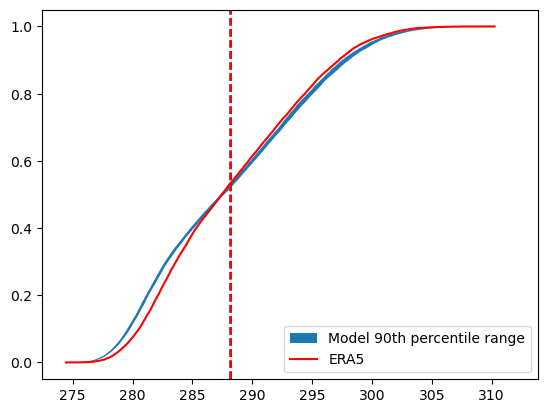

In [104]:
fig, ax = plt.subplots(1, 1)

# ax.plot(ecdf_model["x"].sel(member=1), ecdf_model["y"].sel(member=1))
# ax.plot(ecdf_model["x"].sel(member=2), ecdf_model["y"].sel(member=2))
ax.fill_betweenx(
    ecdf_model["y"].sel(member=1),
    ecdf_model["x"].quantile(0.95, "member"),
    ecdf_model["x"].quantile(0.05, "member"),
label="Model 90th percentile range"
)
ax.axvline(cell_model.mean(["time", "member"]), ls="--")
# ax.plot(ecdf_model["x"].mean("member"), ecdf_model["y"].mean("member"), c="r", lw=0.7)

ax.plot(ecdf_era.x, ecdf_era.y, c="r", label="ERA5")
ax.axvline(cell_era.mean("time"), c="r", ls="--")

ax.legend()